In [1]:
# Load Dependencies
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import vgg19
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import save_img


%matplotlib inline

tfe = tf.contrib.eager

Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

In [3]:
# Constants
HEIGHT = WIDTH = 512
CHANNELS = 3

CONTENT_PATH = '../data/content/turtle.jpg'
STYLE_PATH = '../data/style/van-gogh.jpg'

CONTENT_LAYERS = ['block5_conv2']
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

# Transfer Learning
Neural Style Transfer relies on the use of a trained CNN. Here we will use VGG19!
Let's load our VGG19 model!

In [4]:
def show_img(img, title=''):
    plt.imshow(img)
    if title:
        plt.title(title)
def deprocess_img(img):
    x = img.copy()

    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocess_img()")

    # Inverse of preprocessing
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    # Ensure we're in the range of (0, 255)
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_image(img, path_to_save):
    img = deprocess_img(img)
    save_img(path_to_save, img)
    
def generate_noise_image(path_to_content_img, noise_ratio = 0.6, show = True):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    content_image = load_img(path_to_content_img, target_size=(HEIGHT, WIDTH, CHANNELS))
    content_image = img_to_array(content_image)
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (HEIGHT, WIDTH, CHANNELS)).astype('float32')
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    if show:
        show_img(np.clip(input_image, 0., 255.), 'Generated Image')
    input_image = np.expand_dims(input_image, axis=0)
    input_image = vgg19.preprocess_input(input_image)
    return input_image

def get_image(path_to_image, show = True):
    image = load_img(path_to_image, target_size=(HEIGHT, WIDTH, CHANNELS))
    if show:
        plt.imshow(image)
    image = img_to_array(image).astype('float32')
    image = np.expand_dims(image, axis=0)
    return vgg19.preprocess_input(image)

In [5]:
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(HEIGHT, WIDTH, CHANNELS))
    
    content_layers = [vgg.get_layer(layer_name).output for layer_name in CONTENT_LAYERS]
    style_layers = [vgg.get_layer(layer_name).output for layer_name,coeff in STYLE_LAYERS]
    model_output = content_layers + style_layers
    
    return Model(inputs=vgg.input, outputs=model_output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


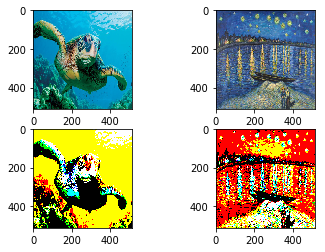

In [6]:
# Test with images
plt.subplot(2, 2, 1)
content_image = get_image(CONTENT_PATH)
content_image = tf.constant(content_image, name='content_image', dtype='float32')

plt.subplot(2, 2, 2)
style_image = get_image(STYLE_PATH)
style_image = tf.constant(style_image, name='style_image', dtype='float32')

plt.subplot(2, 2, 3)
show_img(content_image[0])

plt.subplot(2, 2, 4)
show_img(style_image[0])

plt.show()

In [7]:
def content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    const = 1 / (4 * n_H * n_W * n_C) * tf.reduce_sum(tf.square(tf.subtract(a_C, a_G)))

In [8]:
def gram_matrix(A):
    return tf.matmul(A, tf.transpose(A))

def style_cost_layer(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S_reshaped = tf.reshape(tf.transpose(a_S), [n_C, n_H*n_W])
    a_G_reshaped = tf.reshape(tf.transpose(a_G), [n_C, n_H*n_W])
    
    GS = gram_matrix(a_S_reshaped)
    GG = gram_matrix(a_G_reshaped)
    
    const = 1 / (4 * n_C**2 * (n_H * n_W)**2)
    return const * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))

def style_cost(a_S, a_G):
    J_style = 0
    for i,(layer_name, weight) in enumerate(STYLE_LAYERS):
        curr_a_S = a_S[i]
        curr_a_G = a_G[i]
        J_style += weight * style_cost_layer(curr_a_S, curr_a_G)
    return J_style

In [9]:
def total_cost(a_C, a_S, a_G, model, alpha = 10, beta = 40):
    J_content = content_cost(a_C, a_G[0])
    J_style = style_cost(a_S, a_G[1:])
    print(J_content)
    print(J_style)
    return alpha * J_content + beta * J_style

In [10]:
def get_gradient(a_C, a_S, a_G, model, generated_image):
    with tf.GradientTape() as tape:
        cost = total_cost(a_C, a_S, a_G, model)
    return tape.gradient(cost, generated_image)

In [15]:
def nst_train(a_C, a_S, generated_image, model, num_iterations = 200):    
    optimizer = tf.train.AdamOptimizer(2.0)
    
    for i in range(num_iterations):
        a_G = model(generated_image)
        
        print(content_cost(a_C, a_G[0]))
        
        grads = get_gradient(a_C, a_S, a_G, model, generated_image)
        optimizer.apply_gradients([(grads, generated_image)])
        
        # Print / save image every N iterations
        if i % 10 == 0:
            J_content = compute_content_cost(a_C, a_G[0])
            J_style = compute_style_cost(a_S, a_G[1:])
            J = total_cost(J_content, J_style)
            end_time = time.time()
            print('Total Cost:   {}'.format(J))
            print('Content Cost: {}'.format(J_content))
            print('Style Cost:   {}'.format(J_style))
            print('Saving image: ../images/v3/{}.jpg'.format(i))
            save_image(generated_image.numpy(), '../images/v3/{}.jpg'.format(i))
            print('Image Saved!')
            print('Total Time: ', end_time - start_time, 'secs', '\n')
            start_time = end_time
            show_img(deprocess_img(generated_img), str(i))
            
    save_image(generated_image, '../images/v3/final.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


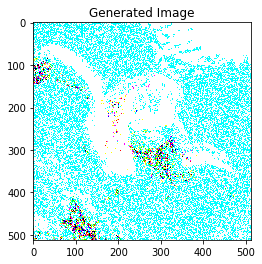

In [27]:
content_image = get_image(CONTENT_PATH)
style_image = get_image(STYLE_PATH)
generated_image = generate_noise_image(CONTENT_PATH)

# content_image = tf.constant(content_image, name='content_image', dtype='float32')
# style_image = tf.constant(style_image, name='style_image', dtype='float32')
generated_image = tfe.Variable(generated_image, name='generated_image', dtype='float32')

In [33]:
model = get_model()

start_time = time.time()

a_C = model(content_image)[0]
a_S = model(style_image)[1:]

a_C = a_C.numpy()
a_S = [layer.numpy() for layer in a_S]

print('Total Time: ', str(time.time() - start_time))

Total Time:  112.12126588821411


In [16]:
nst_train(a_C, a_S, generated_image, model, num_iterations = 1)

None
None
tf.Tensor(3408220700.0, shape=(), dtype=float32)


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [34]:
test_c = np.random.randn(1, HEIGHT, WIDTH, CHANNELS)
test_g = np.random.randn(1, HEIGHT, WIDTH, CHANNELS)

test_g = tfe.Variable(test_g, name='test_g', dtype='float32')

print(content_cost(test_c, test_g))

None


In [35]:
a_C

array([[[[  0.       ,   0.       , 145.29965  , ...,   0.       ,
           78.39478  ,  37.266243 ],
         [  0.       ,   0.       ,   0.7685731, ...,   0.       ,
           81.34502  ,   0.       ],
         [  0.       ,  11.462569 ,  46.00207  , ...,   0.       ,
           29.719032 ,   6.83098  ],
         ...,
         [  0.       ,   0.       ,  10.576819 , ...,   0.       ,
           50.762856 ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
           39.136063 ,   1.9876051],
         [  0.       ,   0.       ,  28.312275 , ...,   0.       ,
           17.785194 ,  57.29422  ]],

        [[  0.       ,   0.       , 138.25876  , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,  44.54343  , ...,   0.       ,
            0.       ,   0.       ],
         ...,
         [ 11.12931  ,   0.       